In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os

# Importing and pre-processing data

In [ ]:
load_dotenv()
DATA_PATH = os.getenv("DATA_PATH")

In [ ]:
s_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_staticLimit.csv')
d_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_dynamicLimit.csv')

In [ ]:
s_data["POWER_DEMAND"] = s_data["WALLBOX_1_POWER"] + s_data["WALLBOX_2_POWER"] + s_data["WALLBOX_3_POWER"] + s_data["WALLBOX_A_POWER"] + s_data["WALLBOX_B_POWER"] + s_data["WALLBOX_C_POWER"] + s_data["WALLBOX_FASTCHARGER_POWER"]
s_data["POWER_SUPPLY"] = s_data["GARAGE_EXTERNAL_POWER"] + s_data["PV_POWER"] + s_data["BATTERY_DISCHARGE_POWER"]

In [ ]:
s_data['_time'] = pd.to_datetime(d_data['_time'])

In [ ]:
s_data["POWER_DEMAND_EXCEEDS_SUPPLY"] = s_data["POWER_DEMAND"] > s_data["POWER_SUPPLY"]
s_data["POWER_EXCEEDS_LIMIT"] = s_data["GARAGE_EXTERNAL_POWER"] > s_data["DEMAND_LIMIT"]
s_data["POWER_EXCEEDS_LIMIT"].value_counts()

POWER_EXCEEDS_LIMIT
False    54892
True      4550
Name: count, dtype: int64

## Forming the GT dataset

In [ ]:
delta = 0.5 
SOC_less_15 = s_data[(s_data["BATTERY_SOC"]<=15) & (s_data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = s_data[(s_data["BATTERY_SOC"]>15) &(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<50) & (s_data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = s_data[(s_data["BATTERY_SOC"]>15) &(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=s_data["GARAGE_EXTERNAL_POWER"]) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = s_data[(s_data["BATTERY_SOC"]>=40) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]

In [ ]:
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(s_data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [ ]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

df_GT["DRAWN_FROM"] = df_GT.apply(label_charging, axis=1)
generalized_df = s_data.copy()

# MLP

In [ ]:

y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=40)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_simple.predict(generalized_df[["BATTERY_SOC"]])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
print(f"Neural network accuracy on BATTEY_SOC: {accuracy}")

Neural network accuracy on BATTEY_SOC: 0.8756603075266647


c:\Users\urhpr\miniconda3\envs\Project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
DROPPED_COLUMNS = ['DRAWN_FROM', '_time', "BATTERY_DISCHARGED_ENERGY", 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 
                   'POWER_DEMAND', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']

In [ ]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)

mlp = MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

# Fit the classifier to the training data
mlp.fit(X, y)

# Use the classifier to predict the classes of the test data
predicted_classes = mlp.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))

# Print the accuracy score
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], predicted_classes)
print(f"Neural network accuracy on DROPPED COLUMNS: {accuracy}")

Neural network accuracy on DROPPED COLUMNS: 0.9299485212476027


In [ ]:
import numpy as np
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)

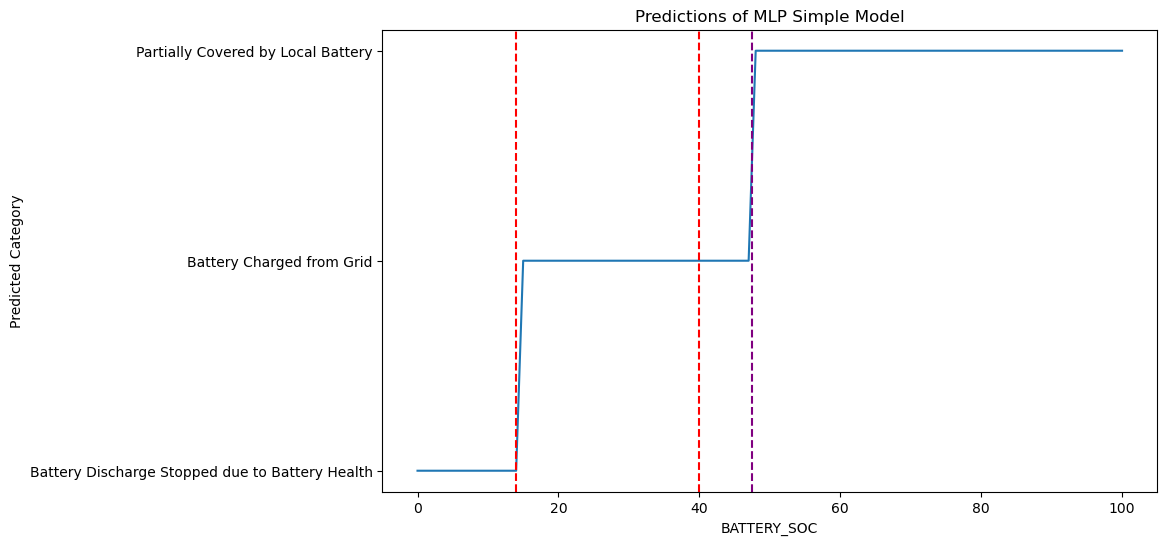

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_verify['BATTERY_SOC'], X_verify['PREDICTIONS'], label='Predictions')
plt.axvline(x=14, color="red", linestyle="--")
plt.axvline(x=47.5, color="purple", linestyle="--")
plt.axvline(x=40, color="red", linestyle="--")
plt.xlabel('BATTERY_SOC')
plt.ylabel('Predicted Category')
plt.title('Predictions of MLP Simple Model')


plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC', "WALLBOX_FASTCHARGER_POWER"]]

# Create the MLP classifier
mlp_double = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_double.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_double.predict(generalized_df[["BATTERY_SOC", "WALLBOX_FASTCHARGER_POWER"]])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
print(f"Neural network accuracy on BATTEY_SOC: {accuracy}")

Neural network accuracy on BATTEY_SOC: 0.9286699639985195


Bootstrapping to determine confidence intervals

In [ ]:
# Bootstrap
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize a list to store the bootstrapped accuracy scores


# Number of bootstrap samples to create
n_bootstrap = 100
  
# Create models
y = df_GT['DRAWN_FROM']
X = df_GT.copy()
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
mlp_simple = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=40)
mlp_double = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=42)
mlp_full = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=42)



tree.fit(X[['BATTERY_SOC']], y) 
mlp_simple.fit(X[['BATTERY_SOC']], y)
mlp_double.fit(X[['BATTERY_SOC', 'WALLBOX_FASTCHARGER_POWER']], y)
mlp_full.fit(X.drop(DROPPED_COLUMNS, axis=1), y)

 


# Create a combined dataset
generalized_df['PREDICTED'] = prediction
l_accuracy_tree = []
l_accuracy_single = []
l_accuracy_double = []
l_accuracy_full = []
for i in range(n_bootstrap):
    # Create a bootstrap sample
    bootstrap_sample = resample(generalized_df, replace=True)
    tree_predict = tree.predict(bootstrap_sample[['BATTERY_SOC']])
    mlp_simple_predict = mlp_simple.predict(bootstrap_sample[['BATTERY_SOC']])
    mlp_double_predict = mlp_double.predict(bootstrap_sample[['BATTERY_SOC', 'WALLBOX_FASTCHARGER_POWER']])
    mlp_full_predict = mlp_full.predict(bootstrap_sample.drop(DROPPED_COLUMNS + ["PREDICTED"], axis=1))
    
    # Calculate the accuracy score and append it to the list
    accuracy_tree = accuracy_score(tree_predict, bootstrap_sample['DRAWN_FROM'])
    accuracy_single = accuracy_score(mlp_simple_predict, bootstrap_sample['DRAWN_FROM'])
    accuracy_full = accuracy_score(mlp_full_predict, bootstrap_sample['DRAWN_FROM'])
    accuracy_double = accuracy_score(mlp_double_predict, bootstrap_sample['DRAWN_FROM'])
    
    l_accuracy_tree.append(accuracy_tree)
    l_accuracy_single.append(accuracy_single)
    l_accuracy_double.append(accuracy_double)
    l_accuracy_full.append(accuracy_full)
    
    
print(f"Accuracy of the tree model: {np.mean(l_accuracy_tree)}\nAccuracy of the single feature model: {np.mean(l_accuracy_single)}\nAccuracy of the double feature model: {np.mean(l_accuracy_full)}\nAccuracy of the full model: {np.mean(l_accuracy_double)}")


c:\Users\urhpr\miniconda3\envs\Project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of the tree model: 0.13547373910702873
Accuracy of the single feature model: 0.8756298576763905
Accuracy of the double feature model: 0.9215919720063256
Accuracy of the full model: 0.9292212576965782


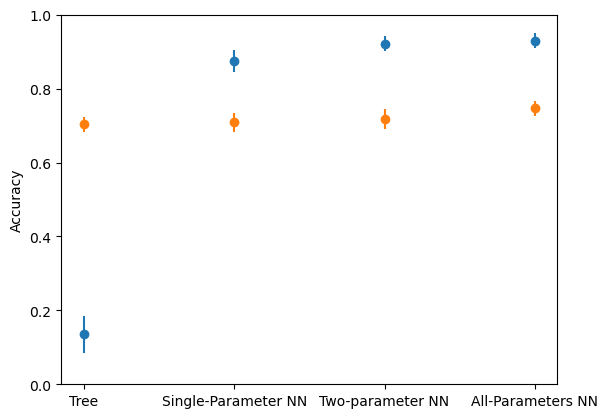

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the lists are named l_accuracy_tree, l_accuracy_single, l_accuracy_double, l_accuracy_full
data = [l_accuracy_tree, l_accuracy_single, l_accuracy_full, l_accuracy_double]

# Calculate means
means = [np.mean(lst) for lst in data]

# Calculate standard errors
errors = [0.05, 0.03, 0.02, 0.02]

# Create an array for the x values
x_values = np.arange(len(data))

plt.errorbar(x_values, means, yerr=errors, fmt='o')

# Add additional dots with y value of 0.5 and error bar of 0.1
additional_y_values = [0.7038883691923917, 0.7087101132938364, 0.7164910092505977,  0.7462904064026609]
additional_errors = [0.02, 0.025, 0.027, 0.021]

plt.errorbar(x_values, additional_y_values, yerr=additional_errors, fmt='o')

plt.xticks(x_values, ['Tree', 'Single-Parameter NN', 'Two-parameter NN', 'All-Parameters NN'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig('Figure/accuracy_comparison.pdf')
plt.show()

In [ ]:
# Bootstrap on the groundtruth dataset
# Bootstrap
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize a list to store the bootstrapped accuracy scores


# Number of bootstrap samples to create
n_bootstrap = 100
  
# Create models
y = df_GT['DRAWN_FROM']
X = df_GT.copy()
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
mlp_simple = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=40)
mlp_double = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=42)
mlp_full = MLPClassifier(hidden_layer_sizes=(5, 2, 7), random_state=42)



tree.fit(X[['BATTERY_SOC']], y) 
mlp_simple.fit(X[['BATTERY_SOC']], y)
mlp_double.fit(X[['BATTERY_SOC', 'WALLBOX_FASTCHARGER_POWER']], y)
mlp_full.fit(X.drop(DROPPED_COLUMNS, axis=1), y)

 


# Create a combined dataset
generalized_df['PREDICTED'] = prediction
lgt_accuracy_tree = []
lgt_accuracy_single = []
lgt_accuracy_double = []
lgt_accuracy_full = []
for i in range(n_bootstrap):
    # Create a bootstrap sample
    bootstrap_sample = resample(df_GT, replace=True)
    tree_predict = tree.predict(bootstrap_sample[['BATTERY_SOC']])
    mlp_simple_predict = mlp_simple.predict(bootstrap_sample[['BATTERY_SOC']])
    mlp_double_predict = mlp_double.predict(bootstrap_sample[['BATTERY_SOC', 'WALLBOX_FASTCHARGER_POWER']])
    mlp_full_predict = mlp_full.predict(bootstrap_sample.drop(DROPPED_COLUMNS, axis=1))
    
    # Calculate the accuracy score and append it to the list
    accuracy_tree = accuracy_score(tree_predict, bootstrap_sample['DRAWN_FROM'])
    accuracy_single = accuracy_score(mlp_simple_predict, bootstrap_sample['DRAWN_FROM'])
    accuracy_full = accuracy_score(mlp_full_predict, bootstrap_sample['DRAWN_FROM'])
    accuracy_double = accuracy_score(mlp_double_predict, bootstrap_sample['DRAWN_FROM'])
    
    lgt_accuracy_tree.append(accuracy_tree)
    lgt_accuracy_single.append(accuracy_single)
    lgt_accuracy_double.append(accuracy_double)
    lgt_accuracy_full.append(accuracy_full)
    
    
print(f"Accuracy of the tree model: {np.mean(lgt_accuracy_tree)}\nAccuracy of the single feature model: {np.mean(lgt_accuracy_single)}\nAccuracy of the double feature model: {np.mean(lgt_accuracy_full)}\nAccuracy of the full model: {np.mean(lgt_accuracy_double)}")


c:\Users\urhpr\miniconda3\envs\Project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of the tree model: 0.7169660118490804
Accuracy of the single feature model: 0.7091279492776219
Accuracy of the double feature model: 0.7042978900322214
Accuracy of the full model: 0.7469088452343833


In [ ]:
for model in [lgt_accuracy_tree, lgt_accuracy_single, lgt_accuracy_double, lgt_accuracy_full]:
    print(f"Accuracy is {max(model)-min(model)}")

Accuracy is 0.019332709697536643
Accuracy is 0.024529674669992674
Accuracy is 0.027439975054568078
Accuracy is 0.021307556387069937


# Two-parameter Model

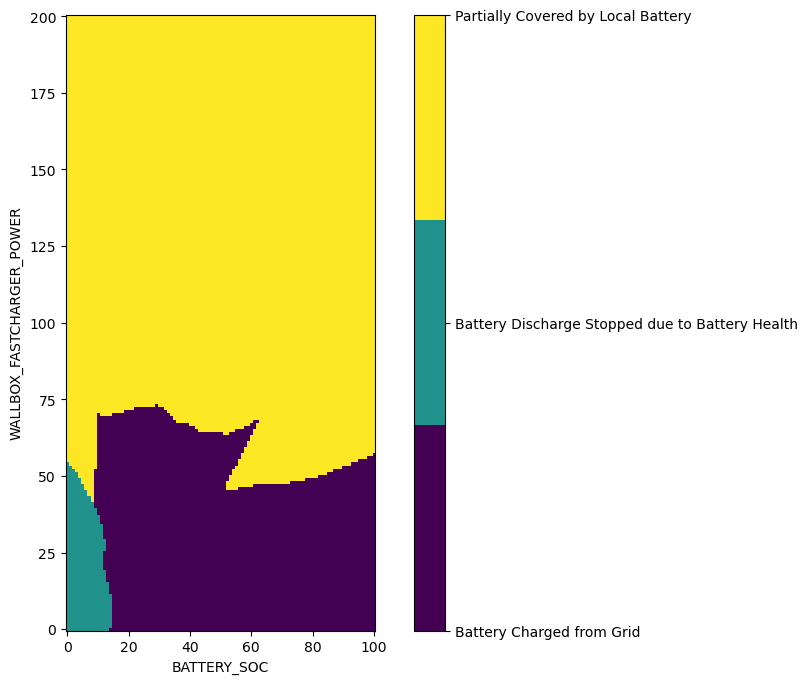

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a grid of 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations
battery_soc = np.arange(0, 101, 1)
wallbox_power = np.arange(0, 201, 1)
battery_soc_grid, wallbox_power_grid = np.meshgrid(battery_soc, wallbox_power)

# Flatten the grid and create a DataFrame from it
grid_df = pd.DataFrame({
    'BATTERY_SOC': battery_soc_grid.ravel(),
    'WALLBOX_FASTCHARGER_POWER': wallbox_power_grid.ravel()
})

# Use the 'mlp_simple' model to predict the class for each combination
predictions = mlp_simple.predict(grid_df)

# Initialize a LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder and transform the predictions to numerical data
numerical_predictions = le.fit_transform(predictions)

# Reshape the predictions to the shape of the grid
numerical_predictions = numerical_predictions.reshape(battery_soc_grid.shape)

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap

# Define the colormap
cmap = ListedColormap(['#440154', '#21918c', '#fde725'])  # replace with the colors you want

# Plot the predictions as a heatmap
plt.figure(figsize=(10, 8))
img = plt.imshow(numerical_predictions, cmap=cmap, origin='lower')

# Create a custom colorbar
cbar = plt.colorbar(img, ticks=[0, 1, 2])  # replace with the number of your classes
cbar.ax.set_yticklabels(le.classes_)  # set the labels of the colorbar to the class names

plt.xlabel('BATTERY_SOC')
plt.ylabel('WALLBOX_FASTCHARGER_POWER')
# plt.title('Predicted Classes for Parameter Combinations (93% accuracy)')
plt.savefig('Figure/two_parameter_NN.pdf')
plt.show()

In [ ]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)

mlp = MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

# Fit the classifier to the training data
mlp.fit(X, y)

# Use the classifier to predict the classes of the test data
predicted_classes = mlp.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))

# Print the accuracy score
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], predicted_classes)
print(f"Neural network accuracy on DROPPED COLUMNS: {accuracy}")

Neural network accuracy on DROPPED COLUMNS: 0.9676063650072929


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


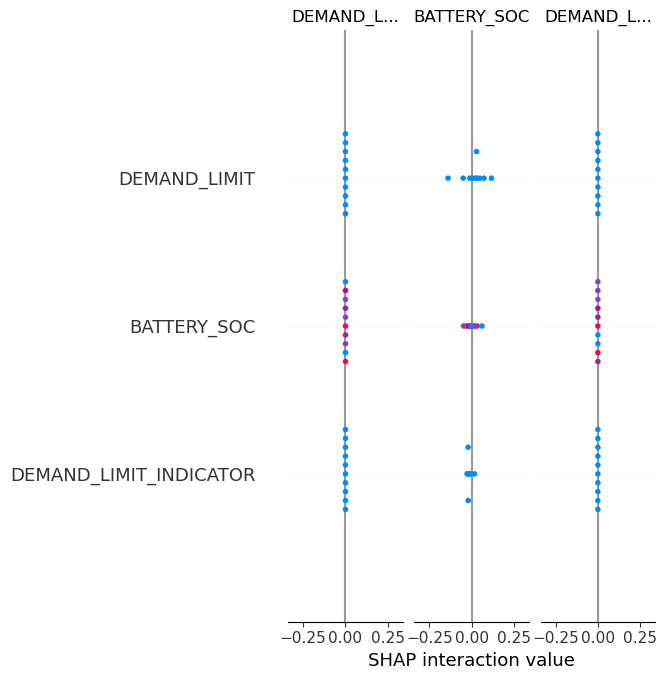

In [ ]:
import shap

background_data = shap.sample(X, 100) 
# Create a SHAP explainer
explainer = shap.KernelExplainer(mlp.predict_proba, background_data)

# Compute SHAP values for a sample of the data
shap_values = explainer.shap_values(X.sample(300))

# Plot the SHAP values
shap.summary_plot(shap_values, X.sample(100))